# K-means / 접근성 분석

In [28]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist, pdist

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
all_center = pd.read_csv("data-set/KNN_data.csv", sep = ",", encoding="euc-kr")
x_test = all_center[all_center['Type'] == "국공립"] 
X = x_test.iloc[:, 14:16]

In [31]:
K = 150

def k_search():
    global K
    KM = [KMeans(n_clusters = k).fit(X) for k in K]
    ss = [silhouette_score(X, k.labels_, metric = 'euclidean') for k in KM]
    centroids = [k.cluster_centers_ for k in KM]
    D_k = [cdist(X, centrds, 'euclidean') for centrds in centroids]
    cIdx = [np.argmin(D, axis = 1) for D in D_k]
    dist = [np.min(D, axis = 1) for D in D_k]
    avgWithinSS = [sum(d) / X.shape[0] for d in dist]
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2 / X.shape[0])
    bss = tss - wcss 
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel("# of clusters")
    plt.ylabel("Avg of ss")
    
    fig2 = plt.figure()
    ax = fig2.add_subplot(111)
    ax.plt(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel("# of cluster")
    plt.ylabel("var")
    plt.show()
    
    '''
    return ss
    
#ss = k_search() # k -- > 구별 25 / 100로 진행

In [32]:
k_means = KMeans(n_clusters = K, max_iter = 3000, random_state = 77)
k_means.fit(X)
k_cluster = k_means.predict(X)
x_test['k_cluster'] = k_cluster

ss = round(silhouette_score(X, k_means.labels_, metric = 'euclidean'),2)
print(ss)

0.41


In [33]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname = "c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family = font_name)

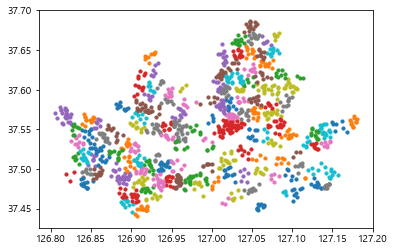

In [34]:
fig = plt.figure()
for i in range(K):
    scat = plt.scatter(x_test[x_test['k_cluster'] == i].iloc[:, 14], 
                       x_test[x_test['k_cluster'] == i].iloc[:, 15], s = 10)
fig.show()

In [44]:
center = k_means.cluster_centers_
groupby = x_test.sort_values(['k_cluster'])

def distance(a,b):
    lon1, lat1 = a[0], a[1]
    lon2, lat2 = float("%.6f" %b[0]), float("%.6f" %b[1])
    R = 6378.137
    dlat = (lat2 - lat1) * (np.pi / 180)
    dlon = (lon2 - lon1) * (np.pi / 180)
    a = np.sin((dlat/2))**2 + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) * (np.sin(dlon/2)) ** 2
    c = 2 * np.math.atan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d
               
def center_access():
    global k_means, center, K, groupby
#     pop = groupby[['201809']]
    groupby['center_access'] = 0.01
    for j in range(len(groupby)):
        tmpList = []
        for i in range(len(center)):
           gb = groupby[groupby['k_cluster'] == i]
           e = np.int(np.mean(gb['201809']))
           dist = distance(groupby.iloc[j, 14:16].values, center[i])
           tmpList.append(e * (dist * 1000) ** -1)
        groupby.iloc[j, -1] = np.sum(tmpList)
#     groupby['mean'] = groupby['center_access'] / K

def people_access():
    global k_means, center, K, groupby
    center = pd.DataFrame(center)
    center['people_access'] = 0.01
    for j in range(len(center)) :
        tmpList = []
        for i in range(len(groupby)):
            center_acc = groupby['center_access'].iloc[i]
            limit = groupby['Max'].iloc[i]
            dist = distance(groupby.iloc[i, 14:16].values, center.iloc[j, :-1].values)
            tmpList.append((limit * (dist * 1000) ** -1) / (center_acc))
        center.iloc[j, -1] = np.sum(tmpList)
               
center_access()
people_access()

In [46]:
groupby['people_access'] = 0
for i in range(len(groupby)):
    groupby.iloc[i, -1] = center['people_access'][groupby['k_cluster'].iloc[i]]
 
# groupby.to_csv("data-set/KK_k150.csv", encoding="euc-kr")

kk_150 = pd.read_csv("data-set/KK_k150.csv", sep = ",", encoding="euc-kr")
kk_150.head()

,Unnamed: 0,Seoul,Gue,Name,Type,Open,Code,Add,Room,Howbig,...,Now,When,X,Y,old_add,201809,predK25,k_cluster,center_access,people_access
0,670,서울특별시,서초,서초장미어린이집,국공립,정상,6733,남부순환로 2543-5,5,318,...,99,1996-07-15,127.028464,37.484204,서초2동,860,1.001950,0,21.502642,0.504548
1,664,서울특별시,서초,서초구립 느티나무어린이집,국공립,정상,6638,사임당로19길 126,4,125,...,40,2017-09-01,127.019912,37.492333,서초1동,904,1.494317,0,25.320775,0.504548
2,665,서울특별시,서초,서초구립 서울교육대학교사향어린이집,국공립,정상,6639,서초중앙로 96,5,179,...,51,2018-01-26,127.015792,37.489983,서초1동,904,0.856335,0,22.289772,0.504548
3,666,서울특별시,서초,서초구립 서초1동하은어린이집,국공립,정상,6632,서초대로58길 35-6,6,309,...,72,2017-09-01,127.018261,37.493166,서초1동,904,1.202833,0,24.998277,0.504548
4,667,서울특별시,서초,서초연꽃어린이집,국공립,정상,6638,사임당로19길 51,7,382,...,156,1998-06-08,127.018042,37.491759,서초1동,904,1.064811,0,23.569974,0.504548
